# The Cost of Basic Goods
## CS146 Location-based Assignment 

# Johannes M. Halkenhaeusser
# Minerva Schools at KGI
# CS146 - Prof. Sheffler
# Spring 2020

In [3]:
450 - 316 
# 134 = 0.63*x+0.03*x**2


134

In [4]:
uploaded = files.upload()

Saving CS146 LBA - Form Responses 1 (1).csv to CS146 LBA - Form Responses 1 (1).csv


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from google.colab import files
import pandas as pd
import pystan
from sklearn.linear_model import LinearRegression

Steps to tackle this problem:
- Clean Data
- Decide distribution of observed prices 
- Find the 2 factors 
    - how are the supermarket prices influenced by location?
    - how are the supermarket prices influenced by brand?
- Write and compile Stan model 
- Plot results 
    - Product
    - Location
    - Store type
- Find Correlation

## Data

The data provided is a cross-sectional sample of ten regular staples from supermarkets in three cities around the world: Buenos Aires, Taipei, and San Francisco. Each price was divided by its quantity to obtain the price per kilogram, unit, or liter. Each location’s nearest subway station as well as the subway line it belongs to has been recorded. 

In [0]:
prices = pd.read_csv('CS146 LBA - Form Responses 1 (1).csv')
prices = pd.DataFrame(prices)

In [0]:
prices['Store No'] = prices['Grocery store'].astype("category").cat.codes
prices['Station No'] = prices['Station'].astype("category").cat.codes
prices['Line No'] = prices['Line'].astype("category").cat.codes

In [144]:
prices.head()

,Timestamp,Email Address,Your name,Grocery store,Grocery store street address,Station,Line,Rent,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9,Store No,Station No,Line No,Price 1,Price 2,Price 3
0,3/2/2020 19:09:54,antoniostark@minerva.kgi.edu,Antonio Stark,Wellcome,"Wellcome, No. 145, Section 1, Heping East Road...",Dongmen Station,Zhonghe-Xinlu,NaN,0.6,198.00,0.4,138.0,1.2,478.0,0.14,20.0,NaN,NaN,NaN,NaN,0.5,158.00,0.5,118.00,0.5,136.0,0.6,118.00,1.0,130.0,1.0,90.0,0.1,21.00,0.1,12.0,1.0,118.00,1.0,253.34,2.5,458.00,1.0,112.66,0.1,17.94,0.1,18.28,0.1,17.86,0.01,16.26,0.1,170.00,0.1,254.4,10.0,190.00,10.0,96.00,10.0,158.00,0.16,198.0,0.25,158.0,0.1,50.0,5,9,9,1237.5,632.0,500.0
1,3/2/2020 23:33:15,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Carrefour,"Carrefour Market, Av. Corrientes 1160, 1043 CA...",9 de Julio,B,4014.0,1.0,69.90,1.0,86.0,1.0,50.0,1.00,94.9,NaN,NaN,NaN,NaN,1.0,84.90,NaN,NaN,NaN,NaN,1.0,26.00,1.0,55.0,1.0,54.9,1.0,46.00,1.0,33.0,1.0,54.90,1.0,53.50,1.0,61.00,1.0,54.50,1.0,40.25,1.0,51.90,1.0,218.50,1.00,545.00,1.0,525.00,1.0,680.0,1.0,9.83,1.0,9.17,1.0,10.25,1.00,239.9,1.00,304.9,NaN,NaN,0,1,2,239.9,304.9,NaN
2,3/2/2020 23:37:17,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Supermercados Día,"Supermercados Día, Av. Corrientes 3534, C1194 ...",Carlos Gardel,B,3750.0,1.0,74.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,92.99,1.0,92.99,NaN,NaN,1.0,34.99,NaN,NaN,NaN,NaN,1.0,40.69,NaN,NaN,NaN,NaN,1.0,59.99,1.0,67.98,1.0,49.99,1.0,52.49,1.0,40.25,1.0,68.99,1.00,489.98,1.0,497.45,1.0,532.9,1.0,9.83,1.0,9.17,1.0,11.33,1.00,312.9,NaN,NaN,NaN,NaN,4,6,2,312.9,NaN,NaN
3,3/3/2020 20:18:11,dennis.antela@minerva.kgi.edu,Dennis Antela Martinez,Jumbo,"Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Ai...",Mtro Carranza,D,5633.0,1.0,80.00,NaN,NaN,NaN,NaN,1.00,84.0,NaN,NaN,NaN,NaN,1.0,99.00,1.0,139.00,1.0,109.0,1.0,44.00,1.0,26.0,1.0,58.0,1.0,40.00,1.0,77.5,1.0,64.00,1.0,54.00,1.0,53.50,1.0,54.50,1.0,69.00,1.0,60.00,1.0,65.00,0.20,125.00,0.2,130.00,0.2,94.0,6.0,92.90,6.0,59.00,6.0,82.90,1.00,293.9,1.00,348.9,NaN,NaN,1,19,6,293.9,348.9,NaN
4,3/4/2020 21:27:02,jasenlo@minerva.kgi.edu,Jasen Lo,Jumbo,"Jumbo, Guardia Vieja 4558, C1192 CABA, Argentina",Ángel Gallardo,B,4874.0,1.0,69.00,1.0,89.0,1.0,159.0,1.00,84.0,NaN,NaN,NaN,NaN,1.0,99.00,1.0,109.00,1.0,139.0,1.0,39.00,1.0,55.0,NaN,NaN,1.0,83.00,1.0,80.0,1.0,66.89,1.0,53.50,1.0,66.00,1.0,54.30,1.0,40.25,1.0,65.00,1.0,69.00,0.10,69.00,0.2,124.70,0.2,130.0,12.0,185.00,12.0,145.00,12.0,99.00,1.00,372.0,NaN,NaN,NaN,NaN,1,32,2,372.0,NaN,NaN


In [0]:
# Because I used the category function to get the a number for the categories, the dict is in a strange order

station_dict = {
    9: 'Dongmen Station',
    1: '9 de Julio',
    6: 'Carlos Gardel',
    19 :'Mtro Carranza',
    32: 'Ángel Gallardo',
    11: 'General San Martin',
    13: 'Independencia',
    30: 'Zhonghe Station',
    26: 'Taipower Building Station',
    27: 'Ximen Station',
    31: 'Zhongxiao Xinsheng Station',
    28: 'Xingtian Temple Station',
    12: 'Guting Station',
    29: 'Yongan Market',
    18: 'Medrano',
    5: 'Callao',
    23: 'Retiro-Mitre',
    22: 'Palermo',
    24: 'Río de Janeiro',
    16: 'Loria',
    17: 'Malabia - O.Pugliese',
    7: 'Catedral',
    25: 'Scalabrini Ortiz',
    8: 'Córdoba',
    14:'Las Heras',
    15: 'Lima',
    21: 'Olleros',
    10: 'Facultad de Medicina',
    20: 'Mtro. Carranza',
    2: 'Alberti',
    0: '16th St Mission',
    3: "Balboa Park Station",
    4: 'Bulnes',
}

store_dict = {
    5: 'Wellcome',
    0: 'Carrefour',
    4: 'Supermercados Día',
    1: 'Jumbo',
    2: 'Safeway',
    3: 'Safeway',
}

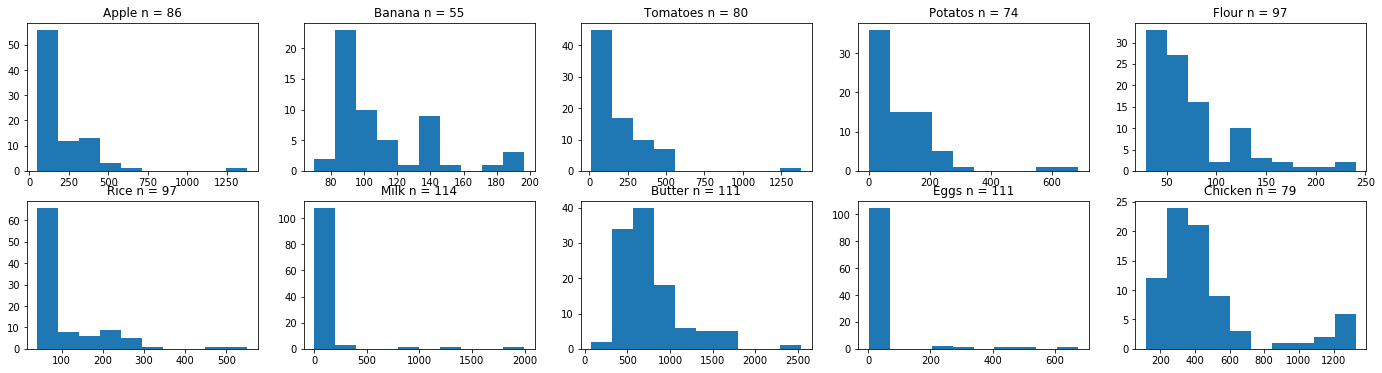

In [66]:
product_dict = {1:"Apple",2:"Banana",3:"Tomatoes",4:"Potatos",5:"Flour",
             6:"Rice",7:"Milk",8:"Butter",9:"Eggs",10:"Chicken"}


#set up the lists for the data input to the stan model
products = []
product_prices = []
store_numbers = []
line_numbers = []
station_numbers = []

n_col = 2
n_row = 5

prod = 0
plt.figure(figsize=(12* n_col, 1.2* n_row))
for i in range(8, len(prices.columns) - 9, 6):

    #to record the product we are dealing with
    prod +=1 
    
    #divide the price by the quantity to get price for 1kg or a unit of one
    #we are creating a column for each price of one product and "sending" the price kg^-1 or unit^-1 or liter^-1 there. 
    prices['Price 1'] = prices[prices.columns[i + 1]]/prices[prices.columns[i]]
    prices['Price 2'] = prices[prices.columns[i + 3]]/prices[prices.columns[i + 2]]
    prices['Price 3'] = prices[prices.columns[i + 5]]/prices[prices.columns[i + 4]]

    #select all the relevant info and most importantly drop all the NAs
    price1 = prices[['Price 1','Store No','Station No', 'Line No']].dropna()
    price2 = prices[['Price 2','Store No','Station No', 'Line No']].dropna()
    price3 = prices[['Price 3','Store No','Station No', 'Line No']].dropna()

    #stack all the prices for one product
    prices_oneproduct = price1['Price 1'].values.tolist() + price2['Price 2'].values.tolist() + price3['Price 3'].values.tolist()
    
    #look at their distribution
    plt.subplot(n_col, n_row, prod)
    plt.hist(prices_oneproduct)
    plt.title(f'{product_dict[prod]} n = {len(prices_oneproduct)}')

    #record the stores so that the appearance of each store is proportional to the number of times it appears in the prices
    product_stores_oneprod = price1['Store No'].values.tolist() + price2['Store No'].values.tolist() + price3['Store No'].values.tolist()
    
    #add the product as often to the product distribution as there are prices
    products_oneprod = len(prices_oneproduct)*[prod]

    #stack the subway line no.
    line_numbers_oneprod = price1['Line No'].values.tolist() + price2['Line No'].values.tolist() + price3['Line No'].values.tolist()
    
    #stack the station no. 
    station_numbers_oneprod = price1['Station No'].values.tolist() + price2['Station No'].values.tolist() + price3['Station No'].values.tolist()
    
    #add them to the master lists
    product_prices += prices_oneproduct
    store_numbers += product_stores_oneprod
    products += products_oneprod
    line_numbers += line_numbers_oneprod
    station_numbers += station_numbers_oneprod

In [251]:
print(products[0:10])
print(product_prices[0:10])
print(store_numbers[0:10])
print(line_numbers[0:10])
print(station_numbers[0:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[330.0, 69.9, 74.99, 80.0, 69.0, 200.0, 180.95238095238096, 280.0, 390.0, 306.6666666666667]
[5, 0, 4, 1, 1, 0, 5, 0, 0, 0]
[9, 2, 2, 6, 2, 5, 8, 3, 9, 9]
[9, 1, 6, 19, 32, 30, 26, 27, 31, 28]


## Let's build the Stan Model 

### The model

The model we are trying to build should give us estimates for the base price and the factors associated with each location and store-type.

Hence, the base price is the unobserved variable that is a combination of the to be estimated parameters: base price, location factor, and store factor. The factors are best modelled by cauchy distributions that are centered around a median of 1. Cauchy distributions are particularly good for modeling these parameters because this half-cauchy (restricting its lowest value at 0) has heavily tails, i.e, letting us model the large uncertainty we have. 

Similarly, with the cauchy for the price centered around 200 with variance 300, we think the median price of a good is 200 but give it a lot of uncertainty. That's because each product should have a different medium but from my shopping experience I think it will be somewhere on the 10^2 order of magnitude and in lower end of that spectrum.

The prices itself are being modelled with a normal distribution. The center of this normal distribution is around the product of the to be estimated parameters. The normal distribution is also floored at 0, so no price can be below 0 Pesos. The variance of the price is also drawn from a normal distribution that is centered around 100 with a variance of 20. Hence, the probability of getting negative values is low already. 

Ultimately we are asking the question what the probability distribution over our base-price given our data about the price and the connection

The output from the model will give us samples for the base price of the ten different produce, the different locations, and the different stores. 

In [0]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  

    // input meta-data
    int n;          // observed prices
    int prod_no;       // no of products
    int store;      // no of store brands
    int subway;     // no of subway stations or lines
    
    // actual observed data
    real<lower=0> prices[n];  
    int product[n];             
    int stores[n];             
    int stations[n];  
    
    //hyperparameters
    real<lower=0> mu;      
    real<lower=0> sig_0;       
    
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {

    real<lower=0> base_price[prod_no];      //the base price we are trying to estimate. The vector contains a slot for each product
    real<lower=0> store_factor[store];    // for each store we are getting the factor centered around 1.
    real<lower=0> location_factor[subway];   //each subway station or line gets factors into the model. Again centered around 1
    
    real<lower=0> sigma;              //randomness for the normal distribution
    
}


// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {

    sigma ~ normal(mu, sig_0);      //make some noise
    
    base_price ~ cauchy(200, 300);
    

    ## the half cauchy is a good scale factor according to Gelman 2006

    store_factor ~ cauchy(1, 0.5); // get the store_factors

    location_factor ~ cauchy(1, 0.5); // get the location factors
    
    for (i in 1:n){
        prices[i] ~ normal(base_price[product[i]] * store_factor[stores[i] + 1] * location_factor[stations[i] + 1], sigma); //likelihood function
  }
}

"""

In [23]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_42ec1452c6ebc89cc49a8205d890f3cc NOW.


In [0]:
data_dict = {
    
    'n': len(product_prices), 
    'prod_no': len(product_dict),
    'store': len(prices['Store No'].unique()),
    'subway': len(prices['Station No'].unique()),

    'prices': product_prices,
    'product': products,     
    'stores': store_numbers,         
    'stations': station_numbers,
    
    'mu': 100,    
    'sig_0': 20,   

}

In [0]:
stan_results = stan_model.sampling(data= data_dict)
posteriors = stan_results.extract()

## Results

### Products

The prices of the different goods are shown in Fig. 1. Butter and Chicken are the most outlier variables that are more expensive than the other goods. However, the distribution of all products is quite wide as shown in table below. Observing the confidence intervals for the prices, they are all quite wide. This is largely affected by the right skew and the large variance in input data prices (see the histograms from the data section). For example, there is an outlier value in the eggs prices that makes a single egg cost around 500 Pesos. This is an unrealistic value.

Butter and Chicken are the most expensive products and have the largest spread. In part this is because they are not as "squished" against the zero bound but also because when observing their input-data, the spread is already wide. 

To check how prices compare on a significance level, I performed t-tests on each pairing at the 5% confidence interval: 

Apple is stat. sig. more expensive than Banana

Apple is stat. sig. cheaper than Tomatoes

Apple is stat. sig. more expensive than Potatos

Apple is stat. sig. more expensive than Flour

Apple is stat. sig. more expensive than Rice

Apple is stat. sig. more expensive than Milk

Apple is stat. sig. cheaper than Butter

Apple is stat. sig. more expensive than Eggs

Apple is stat. sig. cheaper than Chicken

Banana is stat. sig. cheaper than Tomatoes

Banana is stat. sig. cheaper than Potatos

Banana is stat. sig. more expensive than Flour

Banana is stat. sig. cheaper than Rice

Banana is stat. sig. cheaper than Milk

Banana is stat. sig. cheaper than Butter

Banana is stat. sig. more expensive than Eggs

Banana is stat. sig. cheaper than Chicken

Tomatoes is stat. sig. more expensive than Potatos

Tomatoes is stat. sig. more expensive than Flour

Tomatoes is stat. sig. more expensive than Rice

Tomatoes is stat. sig. more expensive than Milk

Tomatoes is stat. sig. cheaper than Butter

Tomatoes is stat. sig. more expensive than Eggs

Tomatoes is stat. sig. cheaper than Chicken

Potatos is stat. sig. more expensive than Flour

Potatos is stat. sig. cheaper than Rice

Potatos is stat. sig. cheaper than Milk

Potatos is stat. sig. cheaper than Butter

Potatos is stat. sig. more expensive than Eggs

Potatos is stat. sig. cheaper than Chicken

Flour is stat. sig. cheaper than Rice

Flour is stat. sig. cheaper than Milk

Flour is stat. sig. cheaper than Butter

Flour is stat. sig. more expensive than Eggs

Flour is stat. sig. cheaper than Chicken

Rice is stat. sig. cheaper than Milk

Rice is stat. sig. cheaper than Butter

Rice is stat. sig. more expensive than Eggs

Rice is stat. sig. cheaper than Chicken

Milk is stat. sig. cheaper than Butter

Milk is stat. sig. more expensive than Eggs

Milk is stat. sig. cheaper than Chicken

Butter is stat. sig. more expensive than Eggs

Butter is stat. sig. more expensive than Chicken

Eggs is stat. sig. cheaper than Chicken


In [0]:
posterior_prices = []

for i in range(1,11):

    name = product_dict[i]
    posterior_prices.append(posteriors['base_price'][:,i -1])

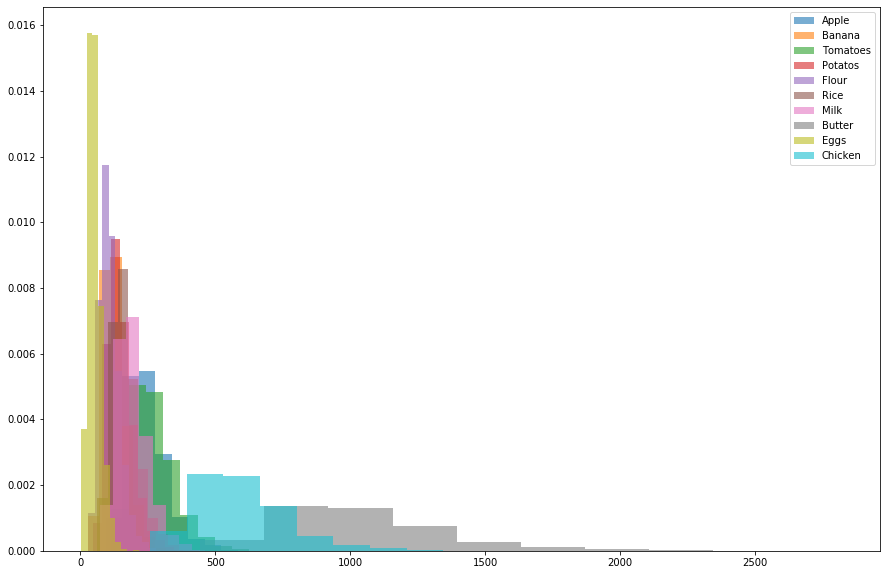

In [231]:
plt.figure(figsize = (15,10))
table_food = []
for i in range(10):
    

    table_food.append([product_dict[i+1],np.mean(posterior_prices[i]), np.percentile(posterior_prices[i], (2.5, 97.5))])
    #there were some extreme outliers in the samples that made the sample histogram out of scale. This is only for Chicken.
    plt.hist(np.sort(posterior_prices[i])[:4000], bins = 10, density = True, label = product_dict[i+1], alpha = 0.6)

plt.legend()

Figure 1. The posterior base price samples.

Table 1. The mean base prices for the different products

In [232]:
df_food = pd.DataFrame(table_food, columns = ['Product', 'Mean Base Price', '95% Conf.int.'])
df_food

,Product,Mean Base Price,95% Conf.int.
0,Apple,246.392944,"[142.64160378234297, 422.51770332592037]"
1,Banana,127.736009,"[64.56634990524856, 229.27089208078092]"
2,Tomatoes,271.965137,"[154.55219009308973, 459.6790865333089]"
3,Potatos,148.909121,"[79.69477077211083, 260.9946797800593]"
4,Flour,108.994020,"[53.64470889454693, 198.34400875022789]"
5,Rice,165.195416,"[89.06195348324172, 291.6075687183091]"
6,Milk,192.959551,"[108.56764535834989, 332.3810627636503]"
7,Butter,1027.527562,"[595.0987932010406, 1745.1244801069895]"
8,Eggs,51.912649,"[14.103664828035173, 111.86388486939187]"
9,Chicken,591.890461,"[342.54716579855364, 1007.6322504820731]"


In [256]:
## Get the test statistics 

for i in range(len(posterior_prices)):

    for j in range(i +1, len(posterior_prices)):

        z, p_value = sts.ttest_ind(posterior_prices[i], posterior_prices[j])

        if p_value > 0.05:
            print(f'{product_dict[i+1]} is not statistically significantly different to {product_dict[j+1]}')

        else: 
            if z > 0: 
                print(product_dict[i+1] + ' is stat. sig. more expensive than ' + product_dict[j+1])
            if z < 0:
                print(product_dict[i+1] + ' is stat. sig. cheaper than ' + product_dict[j+1])

Apple is stat. sig. more expensive than Banana
Apple is stat. sig. cheaper than Tomatoes
Apple is stat. sig. more expensive than Potatos
Apple is stat. sig. more expensive than Flour
Apple is stat. sig. more expensive than Rice
Apple is stat. sig. more expensive than Milk
Apple is stat. sig. cheaper than Butter
Apple is stat. sig. more expensive than Eggs
Apple is stat. sig. cheaper than Chicken
Banana is stat. sig. cheaper than Tomatoes
Banana is stat. sig. cheaper than Potatos
Banana is stat. sig. more expensive than Flour
Banana is stat. sig. cheaper than Rice
Banana is stat. sig. cheaper than Milk
Banana is stat. sig. cheaper than Butter
Banana is stat. sig. more expensive than Eggs
Banana is stat. sig. cheaper than Chicken
Tomatoes is stat. sig. more expensive than Potatos
Tomatoes is stat. sig. more expensive than Flour
Tomatoes is stat. sig. more expensive than Rice
Tomatoes is stat. sig. more expensive than Milk
Tomatoes is stat. sig. cheaper than Butter
Tomatoes is stat. sig. 

### Store Factor

The median of posterior store factor samples is spread around one, as it was designed in the model. 

The significance tests are carried out below.  
I would expect prices in Argentinian stores such as Jumbo or Supermercados Día to be different than those in Taipei. Indeed Jumbo and Supermercados Día are more expensive than Wellcome.
Carrefour which has the highest median store factor is an interesting example, because it was present both in Taipei and in Buenos Aires samples and it is the most expensive supermarket overall. 

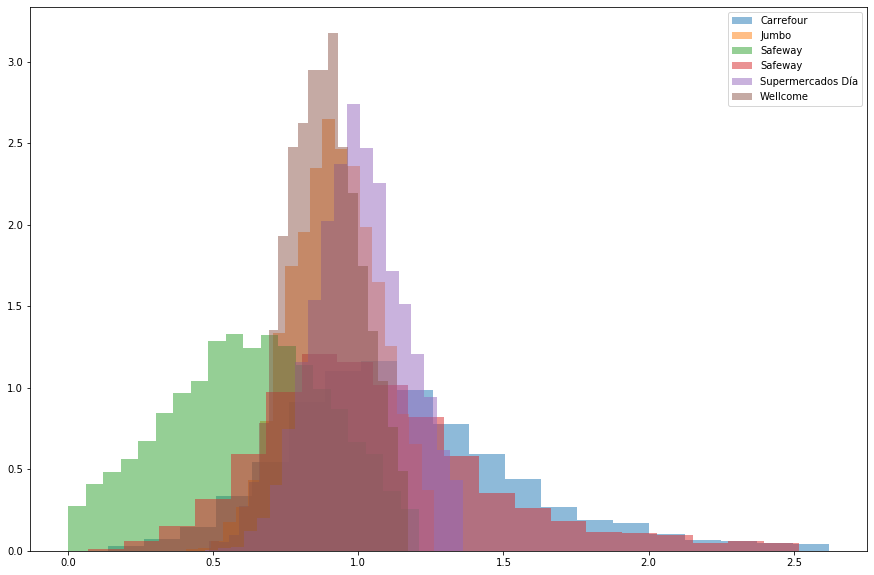

In [244]:
posterior_store_factors = []
plt.figure(figsize = (15,10))

table_store = []
for i in range(len(store_dict)):

    posterior_store_factors.append(posteriors['location_factor'][:,i])
    table_store.append([store_dict[i], np.median(posterior_store_factors[-1]), np.percentile(posterior_store_factors,(2.5, 97.5))])
    plt.hist(np.sort(posterior_store_factors[-1])[:3900], density = True, bins = 20, label = store_dict[i], alpha = .5)


plt.legend()

In [245]:
df_store = pd.DataFrame(table_store, columns =['Store', 'Median Factor', '95% Conf.int.'])
df_store.sort_values(by = ['Median Factor'], ascending=False)

,Store,Median Factor,95% Conf.int.
0,Carrefour,1.116377,"[0.4827505493170915, 2.621534562712923]"
3,Safeway,1.020756,"[0.23123967614446883, 2.123398247237333]"
4,Supermercados Día,1.008260,"[0.26730840334747086, 1.9836793886250728]"
1,Jumbo,0.922034,"[0.5610960212141449, 2.1295437243247384]"
5,Wellcome,0.885010,"[0.2980965276015625, 1.9038432702042072]"
2,Safeway,0.634941,"[0.1922042693991261, 1.9249340583034666]"


In [259]:
## Significance Tests

for i in range(len(posterior_store_factors)):

    for j in range(i +1, len(posterior_store_factors)):

        z, p_value = sts.ttest_ind(posterior_store_factors[i], posterior_store_factors[j])

        if p_value > 0.05:
            print(f'{store_dict[i]} is not statistically significantly different to {store_dict[j]}')

        else: 
            if z > 0: 
                print(store_dict[i] + ' is stat. sig. more expensive than ' + store_dict[j])
            if z < 0:
                print(store_dict[i] + ' is stat. sig. cheaper than ' + store_dict[j])

Carrefour is stat. sig. more expensive than Jumbo
Carrefour is stat. sig. more expensive than Safeway
Carrefour is stat. sig. more expensive than Safeway
Carrefour is stat. sig. more expensive than Supermercados Día
Carrefour is stat. sig. more expensive than Wellcome
Jumbo is stat. sig. more expensive than Safeway
Jumbo is stat. sig. cheaper than Safeway
Jumbo is stat. sig. cheaper than Supermercados Día
Jumbo is stat. sig. more expensive than Wellcome
Safeway is stat. sig. cheaper than Safeway
Safeway is stat. sig. cheaper than Supermercados Día
Safeway is stat. sig. cheaper than Wellcome
Safeway is stat. sig. more expensive than Supermercados Día
Safeway is stat. sig. more expensive than Wellcome
Supermercados Día is stat. sig. more expensive than Wellcome


## Station Factor 

There are 33 different stations. Because there are so many stations that visualizing them all on one plot would be too cluttered, I chose to only visualize the stations in my current city, Buenos Aires. I report the significance tests between the different stations on the last page (they are quite lengthy). By simply looking at the magnitude and spread of the different station prices, they seem to factor in more than the supermarket factor. For this comparison to be made, it was important that the factor priors are distributed by the same cauchy (otherwise the prior would alter the results). 
The difference between Argentine and Taiwanese station factors leaves reason to believe, that Buenos Aires' grocery prices are higher than those in Taipei.

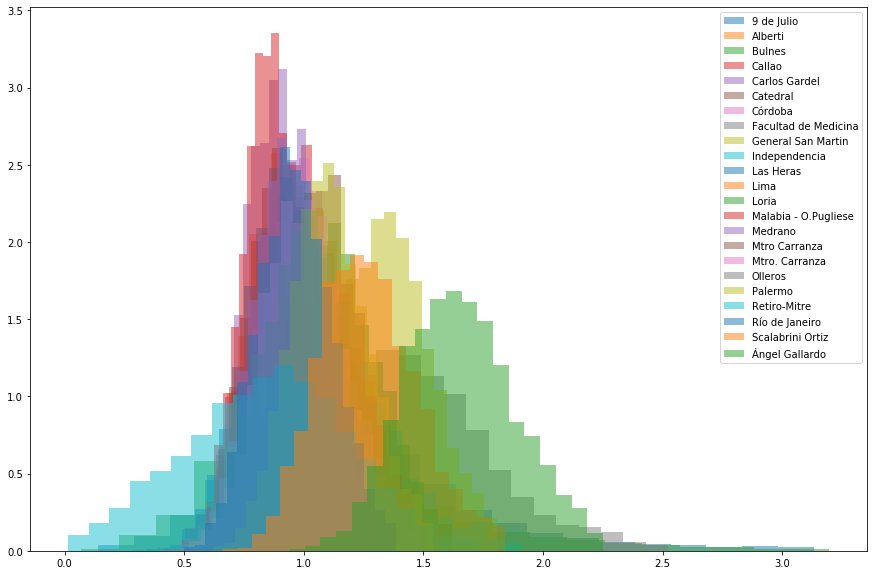

In [260]:
posterior_location_factors = []
plt.figure(figsize = (15,10))
taiwan_post_loc = []
table = []
for i in range(len(station_dict)):

    #Get a histogram just for Buenos Aires vs. Taiwan and SF. 
    if 'Station' in station_dict[i] or 'Market' in station_dict[i] or 'Mission' in station_dict[i]:
        
        taiwan_post_loc.append(posteriors['location_factor'][:,i - 1])
        table.append([station_dict[i] , np.median(taiwan_post_loc[-1]), np.percentile(taiwan_post_loc[-1],(2.5, 97.5)), posteriors['location_factor'][:,i - 1]])
        continue

    posterior_location_factors.append(posteriors['location_factor'][:,i -1])
    table.append([station_dict[i] , np.median(posterior_location_factors[-1]),np.percentile(posterior_location_factors[-1],(2.5, 97.5)), posteriors['location_factor'][:,i - 1]])

    #there were some extreme outliers in the samples that made the sample histogram out of scale.
    plt.hist(np.sort(posterior_location_factors[-1])[:3950], density = True, bins = 20, label = station_dict[i], alpha = .5)


plt.legend()

In [261]:
df_stations = pd.DataFrame(table, columns = ['Station', 'Median Factor', '95% Conf.int.', 'Samples'])
df_stations.sort_values(by = ['Median Factor'], ascending=False)

,Station,Median Factor,95% Conf.int.,Samples
28,Xingtian Temple Station,2.098286,"[1.5860163722761345, 2.743603668514802]","[1.9294341557566652, 1.8245357517376963, 2.205..."
31,Zhongxiao Xinsheng Station,2.068396,"[1.5607929940548086, 2.7023607492093578]","[2.0393275999059215, 1.9620796122754285, 2.057..."
29,Yongan Market,1.810768,"[1.3481964988652555, 2.3839563183174284]","[1.5891724803831049, 1.587445113580639, 1.9883..."
30,Zhonghe Station,1.802746,"[1.3507164425381393, 2.36914431440744]","[1.6318163808896589, 1.6808799320475822, 1.883..."
32,Ángel Gallardo,1.646146,"[1.2323404886372022, 2.161367457823718]","[1.6994291468823903, 1.6188834959699636, 1.684..."
10,Facultad de Medicina,1.437867,"[0.9026345574579653, 2.2932351173349304]","[1.1262946911491845, 1.1131721114131365, 1.495..."
11,General San Martin,1.349587,"[1.0165345531132024, 1.7466877732811872]","[1.5201660196851128, 1.2573423011633456, 1.017..."
25,Scalabrini Ortiz,1.259563,"[0.9115646836677428, 1.7639677429277532]","[1.0133079313475286, 1.1566501527363313, 1.327..."
16,Loria,1.121559,"[0.7721504150860008, 1.54814517777362]","[1.4526837806491986, 1.0707521771372575, 0.911..."
1,9 de Julio,1.116377,"[0.4827505493170915, 2.621534562712923]","[1.0137517391855508, 0.7607948386064526, 0.570..."


#### Regressing on the rent

As shown in the figure below there is a very weak positive correlation between the rent prices in Argentina and the factor of the respective subway station.
However, the R^2 of the regression is quite low (only 0.0377). Visually translated, the spread of the observations is quite large which shows that only little of the variation in factor is explained by the rent. 

A further exploration could use different factors than subway lines for the prices. For example, the north of Buenos Aires is much richer than the south and hence I would expect super market prices there to be higher. 

In [0]:
#add the rent prices provided by the source in the assignment description
df_stations['Rent'] = [None, 4014, 3580, None, 5114, 4031,3750,3860,4480,None, 4457, 4799, None, 3850,5675, 3630,4260, 4600, 4167, 5633,5633, 5600,6050,4600,4400,5720, None, None, None, None, None, None, None]

In [0]:
df_stations_nona = df_stations.dropna()

In [0]:
rents = df_stations_nona['Rent'].values
stat_fac = df_stations_nona['Median Factor']

In [0]:
stat_fac = np.asarray(stat_fac).reshape(-1,1)
rents = np.asarray(rents).reshape(-1,1)

In [0]:
#run the linear regression
reg = LinearRegression()
reg.fit(rents, stat_fac)
reg.score(rents, stat_fac)

y_pred = reg.predict(np.linspace(3500, 6000, 2).reshape(-1,1))

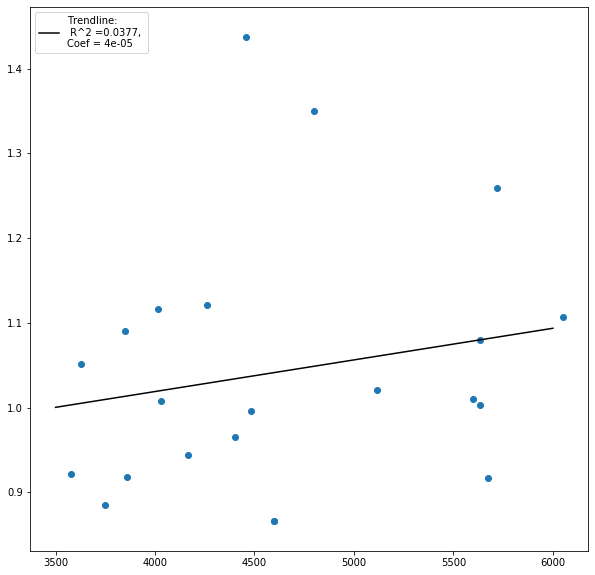

In [250]:
#plot a figure.

plt.figure(figsize = (10,10))
plt.scatter(rents, stat_fac)
plt.plot(np.linspace(3500, 6000, 2), y_pred, color = 'black', label =f'Trendline:\n R^2 ={round(reg.score(rents, stat_fac), 4)}, \nCoef = {round(reg.coef_[0][0], 5)}')
plt.legend(loc = 2)

#### The promised significance tests

In [265]:
## Significance Tests

for i in range(len(df_stations)):

    for j in range(i +1, len(df_stations)):

        z, p_value = sts.ttest_ind(df_stations['Samples'][i], df_stations['Samples'][j])

        if p_value > 0.05:
            print(df_stations['Station'][i] +  'is not statistically significantly different to ' + df_stations['Station'][j])

        else: 
            if z > 0: 
                print(df_stations['Station'][i] + ' is stat. sig. more expensive than ' + df_stations['Station'][j])
            if z < 0:
                print(df_stations['Station'][i] + ' is stat. sig. cheaper than ' + df_stations['Station'][j])

16th St Mission is stat. sig. cheaper than 9 de Julio
16th St Mission is stat. sig. more expensive than Alberti
16th St Mission is stat. sig. more expensive than Balboa Park Station
16th St Missionis not statistically significantly different to Bulnes
16th St Mission is stat. sig. more expensive than Callao
16th St Mission is stat. sig. more expensive than Carlos Gardel
16th St Mission is stat. sig. more expensive than Catedral
16th St Mission is stat. sig. more expensive than Córdoba
16th St Mission is stat. sig. more expensive than Dongmen Station
16th St Mission is stat. sig. cheaper than Facultad de Medicina
16th St Mission is stat. sig. cheaper than General San Martin
16th St Missionis not statistically significantly different to Guting Station
16th St Missionis not statistically significantly different to Independencia
16th St Mission is stat. sig. more expensive than Las Heras
16th St Mission is stat. sig. more expensive than Lima
16th St Mission is stat. sig. cheaper than Loria